# 从0实现线性回归

In [1]:
import sys
sys.path.append('..')
%matplotlib inline
import random
import torch
from utils import *

## 生成数据集
- 生成1000个samples，每个sample包含两个features，即$\mathbf{X} \in \mathbb{R}^{1000 \times 2}$
- 使用线性模型参数$\omega = [2, -3.4]^\top$，$b=4.2$，加上一个均值为0，标准差为0.01的均值为0的噪声项$\epsilon$，
  $$y = \mathbf{X} \omega + b + \mathbf{\epsilon}$$

In [4]:
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

features[0] tensor([0.8404, 0.2431]) 
labels[0] tensor([5.0635])


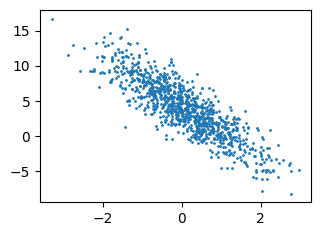

In [5]:
print('features[0]',features[0],'\nlabels[0]',labels[0])

# 画图
set_figsize()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

## 读取数据集
- 每次抽取小批量样本，用其来更新模型。则应定义函数能打乱数据集并选取数据
- data_iter()函数接收batch_size，features和labels，选取一批dataset并返回
- 通常使用GPU并行计算
- 事实上，下面代码执行效率很低，后续会使用深度学习框架

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices=list(range(num_examples))
    # 随机读取，没有顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indeces=torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indeces], labels[batch_indeces]

batch_size=10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n',y)
    break
    

tensor([[-0.4437,  0.5204],
        [-1.2931,  0.3691],
        [-1.4444,  1.6515],
        [ 1.6325,  1.4199],
        [-1.0037, -1.0404],
        [-1.3889,  0.1194],
        [-0.1981,  0.4291],
        [-0.9189, -1.2530],
        [-1.8551, -1.3458],
        [ 0.7342,  0.1220]]) 
 tensor([[ 1.5313],
        [ 0.3561],
        [-4.3056],
        [ 2.6336],
        [ 5.7232],
        [ 1.0136],
        [ 2.3281],
        [ 6.6216],
        [ 5.0553],
        [ 5.2517]])


## 初始化模型参数
- 通过均值0，标准差0.01初始化权重，并将bias初始化为0。
- 初始化之后，任务为更新这些参数，直到参数足够拟合我们的数据。每次你和都要计算损失函数关于模型参数的梯度，并向减小损失的方向更新每个参数

In [8]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)


## 定义模型

In [9]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

## 定义损失函数

In [10]:
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

## 定义优化算法
- 小批量随机梯度下降
- lr：学习率，决定更新的大小
- params：模型参数集合

In [11]:
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

## 训练

In [12]:
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)# X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.048545
epoch2,loss0.000206
epoch3,loss0.000049


In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0001, 0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
